# Mobile Phone Reviews Analysis - Text Mining

## Importing data 

In [64]:
import pandas as pd
import os
import datetime
import nltk 
import re
import numpy as np
import gensim

#Note: You will need to install the packages below to use them
#from textblob import TextBlob
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [65]:
#Just write your directory here
#data_dir = 'C:/Users/owzhe/Downloads/14-million-cell-phone-reviews/'
data_dir = 'C:/Users/Eugene/Desktop/Modules/Text Mining and Language Processing (IS450)/Project/Potential datasets/14-million-cell-phone-reviews/'
reviews_files = os.listdir(data_dir)

reviews_df = pd.DataFrame()

for file in reviews_files:
    current = pd.read_csv(data_dir + file, encoding = "ISO-8859-1")
    reviews_df = reviews_df.append(current)
    

In [66]:
print(len(reviews_df))
reviews_df.head()

1415133


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


## EDA 

In [67]:
# Taking only the reviews that are in english
reviews_en_df = reviews_df[reviews_df['lang'] == 'en']
print(len(reviews_en_df))
reviews_en_df.head()

554746


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [68]:
print(len(reviews_en_df['phone_url'].unique()))
print(reviews_en_df['phone_url'].unique())

4533
['/cellphones/samsung-galaxy-s8/'
 '/cellphones/samsung-galaxy-s6-edgeplus/'
 '/cellphones/samsung-galaxy-s8-plus/' ... '/cellphones/ericsson-pf-768/'
 '/cellphones/motorola-m3288/' '/cellphones/maxon-mx-3204/']


In [69]:
# Creating the function to return the phone model from the URL
def phone_model(url):
    phone_type = ' '.join(url[12:-1].split('-')).title()
    return phone_type

In [70]:
# Applying the phone_model function on the url 
reviews_en_df['phone_model'] = reviews_en_df['phone_url'].apply(phone_model)

C:\Users\Eugene\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
print(len(reviews_en_df['phone_model'].unique()))

4533


In [72]:
# Creating another copy of the reviews_df
reviews_copy_df = reviews_en_df.copy()

In [73]:
# Found out that the dates are abit off - majority are in month/day/year but there is around 20k that is day/month/year
def check_date(row_date):
    month, day, year = row_date.split('/')
    isValid = True
    try:
        datetime.datetime(int(year), int(month), int(day))
    except:
        isValid = False
    
    return isValid

In [74]:
# Creating a year column
def review_year(row_date):
    month, day, year = row_date.split('/')

    return year

In [75]:
reviews_copy_df['date_check'] = reviews_copy_df['date'].apply(check_date)
reviews_copy_df['year'] = reviews_copy_df['date'].apply(review_year)
reviews_copy_df.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product,phone_model,date_check,year
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8,Samsung Galaxy S8,True,2017
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8,Samsung Galaxy S8,True,2017
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl...",Samsung Galaxy S8,True,2017
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T),Samsung Galaxy S8,True,2017
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8,Samsung Galaxy S8,True,2017


In [76]:
# Checking the number of wrong and correct dates 
wrong_dates = reviews_copy_df[reviews_copy_df['date_check'] == False]
print('No. of wrong dates:', len(wrong_dates))

correct_dates = reviews_copy_df[reviews_copy_df['date_check'] == True]
print('No. of correct dates:', len(correct_dates))

No. of wrong dates: 23448
No. of correct dates: 531298


In [77]:
# Created a function to clean the date for the incorrect date format
def clean_date(date):
    month, day, year = date.split('/')
    return '/'.join([day, month, year])

#     for index, row in reviews_df.iterrows():
#         month, day, year = row['date'].split('/')
#         if row['date_check'] == False:
#             reviews_df.loc[index, 'date'] = '/'.join([day, month, year])
#             row['date_check'] = True
#     return reviews_df

In [78]:
# Clean up the date format of the dataframe with wrong dates
wrong_dates['date'] = wrong_dates['date'].apply(clean_date)
wrong_dates

C:\Users\Eugene\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product,phone_model,date_check,year
1,/cellphones/samsung-s7262-duos-galaxy-ace/,11/17/2015,en,in,Zopper,zopper.com,10.0,10.0,Decent Functions and Easy to Operate Pros:- Th...,Expert Review,Samsung Galaxy Star Pro S7262 Black,Samsung S7262 Duos Galaxy Ace,False,2015
2,/cellphones/samsung-s7262-duos-galaxy-ace/,10/29/2015,en,in,Amazon,amazon.in,4.0,10.0,Not Good Phone such price. Hang too much and v...,Amazon Customer,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
3,/cellphones/samsung-s7262-duos-galaxy-ace/,10/29/2015,en,in,Amazon,amazon.in,6.0,10.0,not bad for features,Amazon Customer,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
4,/cellphones/samsung-s7262-duos-galaxy-ace/,10/29/2015,en,in,Amazon,amazon.in,10.0,10.0,Excellent product,NHK,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
5,/cellphones/samsung-s7262-duos-galaxy-ace/,10/27/2015,en,in,Amazon,amazon.in,8.0,10.0,Good in reasonable price,Rupali,Samsung Galaxy Star Pro GT-S7262 (Midnight Black),Samsung S7262 Duos Galaxy Ace,False,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97303,/cellphones/motorola-razr-432872/,5/13/2006,en,gb,Ciao,ciao.co.uk,8.0,10.0,I bought this phone originally because I decid...,tblake7,Motorola RAZR,Motorola Razr 432872,False,2006
97304,/cellphones/motorola-razr-432872/,3/18/2006,en,gb,Ciao,ciao.co.uk,8.0,10.0,"After making the switch from an old V60 TDMA, ...",sting_of_the_scorpion,Motorola RAZR,Motorola Razr 432872,False,2006
97906,/cellphones/alcatel-ot-918d/,1/30/2015,en,us,Amazon,amazon.com,10.0,10.0,Excelente producto,norbys moreno,Alcatel One Touch 918S Mix Unlocked GSM Phone ...,Alcatel Ot 918D,False,2015
97910,/cellphones/alcatel-ot-918d/,11/25/2013,en,us,Amazon,amazon.com,4.0,10.0,"Older Android version, too many junky apps and...","Amazon Customer ""Jarod""",Alcatel One Touch 918S Mix Unlocked GSM Phone ...,Alcatel Ot 918D,False,2013


In [79]:
# Returning the cleaned dataframe use for analysis 
cleaned_df = correct_dates.append(wrong_dates, ignore_index=True)
cleaned_df = cleaned_df[cleaned_df['year'].astype(int) >= 2013]
cleaned_df.drop(columns=['phone_url', 'date_check', 'year'], inplace=True)

In [80]:
# Checking null rows
null_columns = cleaned_df.columns[cleaned_df.isna().any()]
cleaned_df[null_columns].isna().sum()

score         158
score_max     158
extract      3448
author        305
dtype: int64

In [81]:
cleaned_df.dropna(subset=['extract'], inplace=True)
len(cleaned_df)

400063

In [82]:
#Removing pre-2007 reviews
# date_list = cleaned_df.loc[:,'date'].tolist()
# year_list = []
# for dates in date_list:
#     year = dates[-4:]
#     if (int(year)>=2007):
#         year_list.append(year)
#     else:
#         year_list.append("drop")
# cleaned_df.insert(0, 'year', year_list)
# cleaned_df.drop( cleaned_df[ cleaned_df['year'] == "drop" ].index , inplace=True)
# cleaned_df.drop(['year'], axis=1, inplace = True)
# len(cleaned_df)

## Storing/Opening pickle file for the cleaned dataframe 

In [83]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE CLEANED DATAFRAME FROM ABOVE @@@@@@@@@###
# pickle.dump(cleaned_df, open("cleaned_reviews_df.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE CLEANED DATAFRAME FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
#cleaned_df = pickle.load(open("C:/Users/owzhe/OneDrive/Documents/GitHub/phone-reviews-analysis/Pickle Files/cleaned_reviews_df.pkl", "rb"))

In [84]:
cleaned_df.head()

,date,lang,country,source,domain,score,score_max,extract,author,product,phone_model
0,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8,Samsung Galaxy S8
1,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8,Samsung Galaxy S8
2,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl...",Samsung Galaxy S8
3,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T),Samsung Galaxy S8
4,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8,Samsung Galaxy S8


In [85]:
## Create an index series to find back the actual extract later on
import numpy as np
import pandas as pd

data_len = len(cleaned_df)
index_series = np.arange(data_len)

cleaned_df['index'] = index_series

cleaned_df

,date,lang,country,source,domain,score,score_max,extract,author,product,phone_model,index
0,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8,Samsung Galaxy S8,0
1,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8,Samsung Galaxy S8,1
2,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl...",Samsung Galaxy S8,2
3,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T),Samsung Galaxy S8,3
4,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8,Samsung Galaxy S8,4
...,...,...,...,...,...,...,...,...,...,...,...,...
554608,3/18/2014,en,us,Amazon,amazon.com,8.0,10.0,I love this phone! The only problem I have is ...,"Brandi ""Brandi""",Motorola Droid RAZR 4G LTE Android Smartphone ...,Motorola Razr 432872,400058
554609,1/21/2014,en,us,Amazon,amazon.com,10.0,10.0,I love the 4G internet. I like all of the appl...,Amazon Customer,Motorola Droid RAZR 4G LTE Android Smartphone ...,Motorola Razr 432872,400059
554610,8/30/2013,en,us,Amazon,amazon.com,10.0,10.0,This phone works great. Is in good condition. ...,roshanda,Motorola Droid RAZR 4G LTE Android Smartphone ...,Motorola Razr 432872,400060
554743,1/30/2015,en,us,Amazon,amazon.com,10.0,10.0,Excelente producto,norbys moreno,Alcatel One Touch 918S Mix Unlocked GSM Phone ...,Alcatel Ot 918D,400061


In [86]:
sentence_list = []
index_list = []
scores = cleaned_df['score'].tolist()
index_score_list = []

extract_list = list(cleaned_df['extract'])

for num in index_series:
    sentences = extract_list[num]
    sentence_break = sentences.split('.')
    for sentence in sentence_break:
        if len(sentence) > 0:
            sentence_list.append(sentence.strip())
            index_list.append(num)
            index_score_list.append(scores[num])

In [87]:
sentences_df = pd.DataFrame()
sentences_df['sentence'] = sentence_list
sentences_df['index'] = index_list

sentences_df.dropna(inplace=True)

sentences_df

,sentence,index
0,As a diehard Samsung fan who has had every Sam...,0
1,I am amazed at some of the reviews and think p...,0
2,The battery life is amazing,0
3,Love the phone,1
4,the phone is sleek and smooth and beautiful I ...,1
...,...,...
983119,Came right on timr,400060
983120,Excelente producto,400061
983121,"Older Android version, too many junky apps and...",400062
983122,I had one die and returned it to my cell provi...,400062


#  #1 LDA Gensim Model - All Text 

In [88]:
import nltk 
import re

def clean_sentence(sentence_list):
    stop_list = nltk.corpus.stopwords.words('english')
    tokenizer = nltk.tokenize.word_tokenize

    sentence_list  = [tokenizer(sentence.lower()) for sentence in sentence_list]
    sentence_list = [[w for w in sentence if re.search('^[a-z]+$',w)] for sentence in sentence_list]
    sentence_list = [[w for w in sentence if w not in stop_list] for sentence in sentence_list]

    return sentence_list

In [89]:
sentence_list = sentences_df['sentence'].values.tolist()
sentences_df['bag of words'] = clean_sentence(sentence_list)

KeyboardInterrupt: 

In [ ]:
sentences_words = sentences_df['bag of words'].values.tolist()

In [62]:
import gensim

# Using gensim to create a dictionary object of all the words in all extracts
sentence_dict = gensim.corpora.Dictionary(sentences_words)

# Returning the word vector for each extract from the gensim dict of words
sentence_vecs = [sentence_dict.doc2bow(words) for words in sentences_words]

In [63]:
# Finding the optimal number of topics
from gensim.models import CoherenceModel

iterations = 100
passes = 1
gensim_all_texts_list = []

for num_topic in range(3, 10):
    model_val = []
    gensim_all_texts = gensim.models.ldamodel.LdaModel(corpus=sentence_vecs, id2word=sentence_dict, num_topics=num_topic, iterations = iterations, passes = passes)
    coh_model = CoherenceModel(model=gensim_all_texts, texts=sentences_words, dictionary=sentence_dict, coherence='c_v')
    model_val.append(gensim_all_texts)
    model_val.append(coh_model.get_coherence())
    model_val.append(num_topic)
    gensim_all_texts_list.append(model_val)
    print("Topic " + str(num_topic) + " Score: " + str(coh_model.get_coherence()))

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

coh_val = [coh for model, coh, topic in gensim_all_texts_list]

x = range(3, 10)
plt.plot(x, coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Gensim LDA Model - topics

for model in gensim_all_texts_list:
    print("Model #{} Coherence Score: {}".format(model[2], model[1]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    print('----------------------------------------------------------------------------')

In [ ]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE GENSIM MODELS FROM ABOVE @@@@@@@@@###
#pickle.dump(gensim_all_texts_list, open("gensim_all_texts.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# gensim_models = pickle.load(open("gensim_all_texts.pkl", "rb"))

# #1 LDA Mallet Model - All Text

In [ ]:
import gensim
import os 

os.environ.update({'MALLET_HOME':r'D:\\Softwares\\mallet-2.0.8'})
mallet_path = r'D:\\Softwares\\mallet-2.0.8\\bin\\mallet'

mallet_all_texts_list = []

for num_topic in range(3, 10):
    model_val = []
    mallet_all_texts = gensim.models.wrappers.LdaMallet(mallet_path, corpus=sentence_vecs, id2word=sentence_dict, num_topics=num_topic)
    mallet_coh_model = CoherenceModel(model=mallet_all_texts, texts=sentences_words, dictionary=sentence_dict, coherence='c_v')
    model_val.append(mallet_all_texts)
    model_val.append(mallet_coh_model.get_coherence())
    model_val.append(num_topic)
    mallet_all_texts_list.append(model_val)
    print("Topic " + str(num_topic) + " Score: " + str(mallet_coh_model.get_coherence()))

In [ ]:
import matplotlib.pyplot as plt

mallet_coh_val = [coh for model, coh, topic in mallet_all_texts_list]

x = range(3, 10)
plt.plot(x, mallet_coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Mallet LDA Model - topics

for model in mallet_all_texts_list:
    print("Model #{} Coherence Score: {}".format(model[2], model[1]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    print('----------------------------------------------------------------------------')

In [ ]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(mallet_all_texts_list, open("mallet_all_texts.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# gensim_models = pickle.load(open("mallet_all_texts.pkl", "rb"))

# #2 LDA Gensim Model - Nouns Only

In [ ]:
sentences_df = pd.DataFrame()
sentences_df['sentence'] = sentence_list
sentences_df['index'] = index_list
sentences_df.dropna(inplace=True)

sentences_df.head()

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

In [ ]:
import nltk

stop_list = nltk.corpus.stopwords.words('english')
tokenizer = nltk.tokenize.word_tokenize
extra_stop_words = ['phone', 'iphone', 'nokia', 'samsung', 'htc', 'lg', 'galaxy', 'ca', 'motorola', 'android', 'verizon', 'i', '%', 't', 's']

def get_nouns(sentence_row):

    noun_list = []
    sentence = nltk.pos_tag(tokenizer(sentence_row.lower()))
    for w, pos in sentence: 
        if pos == 'NN' and w not in extra_stop_words:
            noun_list.append(w)
    
    return noun_list

#     sentence_list = [tokenizer(sentence.lower()) for sentence in sentence_list]
#     sentence_tagging = [nltk.pos_tag(sentence) for sentence in sentence_list] 
#     sentence_nouns = [w for w in sentence if is_noun(w) for sentence in sentence_list]

In [ ]:
sentences_df['sentence_tags'] = sentences_df['sentence'].apply(get_nouns)

In [ ]:
sentences_df = sentences_df[sentences_df['sentence_tags'].str.len()>0]

In [ ]:
sentences_df.head()

In [ ]:
sentence_tags = sentences_df['sentence_tags'].values.tolist()

In [ ]:
import gensim

# Using gensim to create a dictionary object of all the words in all extracts
sentence_dict = gensim.corpora.Dictionary(sentence_tags)

# Returning the word vector for each extract from the gensim dict of words
sentence_vecs = [sentence_dict.doc2bow(words) for words in sentence_tags]

In [ ]:
# Finding the optimal number of topics
from gensim.models import CoherenceModel

gensim_noun_models = []

for num_topic in range(3, 10):
    model_val = []
    gensim_nouns = gensim.models.ldamodel.LdaModel(corpus=sentence_vecs, id2word=sentence_dict, num_topics=num_topic)
    coh_model = CoherenceModel(model=gensim_nouns, texts=sentence_tags, dictionary=sentence_dict, coherence='c_v')
    model_val.append(gensim_nouns)
    model_val.append(coh_model.get_coherence())
    model_val.append(num_topic)
    gensim_noun_models.append(model_val)
    print("Topic " + str(num_topic) + " Score: " + str(coh_model.get_coherence()))

In [ ]:
import matplotlib.pyplot as plt

coh_val = [coh for model, coh, topic in gensim_noun_models]

x = range(3, 10)
plt.plot(x, coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Mallet LDA Model - topics
for model in gensim_noun_models:
    print("Model #{} Coherence Score: {}".format(model[2], model[1]))
    topics = model[0].show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    print('----------------------------------------------------------------------------')

In [ ]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(gensim_noun_models, open("gensim_noun_models.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# gensim_models = pickle.load(open("gensim_noun_models.pkl", "rb"))

# #2 LDA Mallet Model - Nouns Only

In [ ]:
import gensim
import os 

os.environ.update({'MALLET_HOME':r'D:\\Softwares\\mallet-2.0.8'})
mallet_path = r'D:\\Softwares\\mallet-2.0.8\\bin\\mallet'

mallet_noun_models = []

for num_topic in range(3, 10):
    model_val = []
    mallet_nouns_only = gensim.models.wrappers.LdaMallet(mallet_path, corpus=sentence_vecs, id2word=sentence_dict, num_topics=num_topic)
    mallet_coh_model = CoherenceModel(model=mallet_nouns_only, texts=sentence_tags, dictionary=sentence_dict, coherence='c_v')
    model_val.append(mallet_nouns_only)
    model_val.append(mallet_coh_model.get_coherence())
    model_val.append(num_topic)
    mallet_noun_models.append(model_val)
    print("Topic " + str(num_topic) + " Score: " + str(mallet_coh_model.get_coherence()))

In [ ]:
import matplotlib.pyplot as plt

mallet_coh_val = [coh for model, coh, topic in mallet_noun_models]

x = range(3, 10)
plt.plot(x, mallet_coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Mallet LDA Model - topics
for model in mallet_noun_models:
    print("Model #{} Coherence Score: {}".format(model[2], model[1]))
    topics = model[0].show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    print('----------------------------------------------------------------------------')

In [ ]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(mallet_noun_models, open("mallet_noun_models.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# gensim_models = pickle.load(open("mallet_noun_models.pkl", "rb"))

# #3 LDA Gensim Model - Nouns and Adjectives

In [ ]:
sentences_df = pd.DataFrame()
sentences_df['sentence'] = sentence_list
sentences_df['index'] = index_list
sentences_df.dropna(inplace=True)

sentences_df.head()

In [115]:
import nltk

stop_list = nltk.corpus.stopwords.words('english')
tokenizer = nltk.tokenize.word_tokenize
extra_stop_words = ['phone', 'iphone', 'nokia', 'samsung', 'htc', 'lg', 'galaxy', 'ca', 'motorola', 'android', 'verizon', 'i', '%', 't', 's']
extra_stop_words += ['s4', 's5', 's6', 's7', 's3', 's8', 's9', 'm9', 'moto']

def get_nouns_adj(sentence_row):

    noun_list = []
    sentence = nltk.pos_tag(tokenizer(sentence_row.lower()))
    for w, pos in sentence: 
        if pos == 'NN' or pos == 'JJ':
            if w not in extra_stop_words:
                noun_list.append(w)
    
    return noun_list


In [116]:
sentences_df['sentence_tags'] = sentences_df['sentence'].apply(get_nouns_adj)

In [117]:
sentences_df.head()

,sentence,index,sentence_tags
0,As a diehard Samsung fan who has had every Sam...,0,"[diehard, fan, series, favorite, upgrade]"
1,I am amazed at some of the reviews and think p...,0,"[defective, device]"
2,The battery life is amazing,0,"[battery, life]"
4,the phone is sleek and smooth and beautiful I ...,1,"[sleek, smooth, beautiful]"
5,Adequate feel,2,"[adequate, feel]"


In [119]:
sentences_df = sentences_df[sentences_df['sentence_tags'].str.len()>0]
sentences_df.head()

,sentence,index,sentence_tags
0,As a diehard Samsung fan who has had every Sam...,0,"[diehard, fan, series, favorite, upgrade]"
1,I am amazed at some of the reviews and think p...,0,"[defective, device]"
2,The battery life is amazing,0,"[battery, life]"
4,the phone is sleek and smooth and beautiful I ...,1,"[sleek, smooth, beautiful]"
5,Adequate feel,2,"[adequate, feel]"


In [120]:
sentence_tags = sentences_df['sentence_tags'].values.tolist()

In [121]:
import gensim

# Using gensim to create a dictionary object of all the words in all extracts
sentence_dict = gensim.corpora.Dictionary(sentence_tags)

# Returning the word vector for each extract from the gensim dict of words
sentence_vecs = [sentence_dict.doc2bow(words) for words in sentence_tags]

In [122]:
# Finding the optimal number of topics
from gensim.models import CoherenceModel

gensim_noun_adj_models = []
coh_val = []
model_topics = []

for num_topic in range(3, 10):
    model_val = []
    gensim_nouns_adj = gensim.models.ldamodel.LdaModel(corpus=sentence_vecs, id2word=sentence_dict, num_topics=num_topic)
    coh_model = CoherenceModel(model=gensim_nouns_adj, texts=sentence_tags, dictionary=sentence_dict, coherence='c_v')
    model_val.append(gensim_nouns_adj)
    model_val.append(coh_model.get_coherence())
    model_val.append(num_topic)
    gensim_noun_adj_models.append(model_val)
    print("Topic " + str(num_topic) + " Score: " + str(coh_model.get_coherence()))

Topic 3 Score: 0.12090471406217408
Topic 4 Score: 0.12379088351916395
Topic 5 Score: 0.17597729267955997
Topic 6 Score: 0.16647013832319194
Topic 7 Score: 0.18916878754844113
Topic 8 Score: 0.19107144666320994
Topic 9 Score: 0.1849763089123704


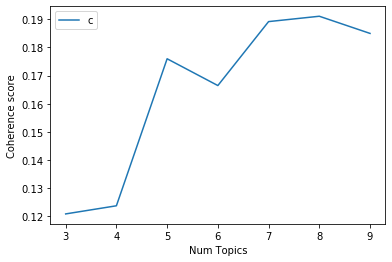

In [130]:
import matplotlib.pyplot as plt

gensim_coh_val = [coh for model, coh, topic in gensim_noun_adj_models]

x = range(3, 10)
plt.plot(x, gensim_coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [131]:
# Mallet LDA Model - topics
for model in gensim_noun_adj_models:
    print("Model #{} Coherence Score: {}".format(model[2], model[1]))
    topics = model[0].show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    print('----------------------------------------------------------------------------')

Model #3 Coherence Score: 0.12090471406217408
Topic 1: good, screen, easy, sim, card, old, little, money, year, bad
Topic 2: new, time, other, first, mobile, product, happy, day, few, basic
Topic 3: great, battery, price, camera, quality, nice, life, excellent, everything, smartphone
----------------------------------------------------------------------------
Model #4 Coherence Score: 0.12379088351916395
Topic 1: good, product, other, money, bad, thing, little, internet, work, charger
Topic 2: great, screen, quality, nice, camera, mobile, everything, smartphone, problem, smart
Topic 3: price, new, easy, first, excellent, old, year, many, lot, cell
Topic 4: battery, time, life, sim, card, happy, day, apps, few, memory
----------------------------------------------------------------------------
Model #5 Coherence Score: 0.17597729267955997
Topic 1: good, great, price, product, nice, service, last, simple, call, month
Topic 2: battery, good, camera, easy, quality, life, great, excellent, 

In [132]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(gensim_noun_adj_models, open("gensim_noun_adj_models.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# gensim_models = pickle.load(open("gensim_noun_adj_models.pkl", "rb"))

# #3 LDA Mallet Model - Nouns and Adjectives

In [133]:
import gensim
import os 

os.environ.update({'MALLET_HOME':r'D:\\Softwares\\mallet-2.0.8'})
mallet_path = r'D:\\Softwares\\mallet-2.0.8\\bin\\mallet'

mallet_noun_adj_models = []

for num_topic in range(3, 10):
    model_val = []
    mallet_noun_adj = gensim.models.wrappers.LdaMallet(mallet_path, corpus=sentence_vecs, id2word=sentence_dict, num_topics=num_topic)
    mallet_coh_model = CoherenceModel(model=mallet_noun_adj, texts=sentence_tags, dictionary=sentence_dict, coherence='c_v')
    model_val.append(mallet_noun_adj)
    model_val.append(mallet_coh_model.get_coherence())
    model_val.append(num_topic)
    mallet_noun_adj_models.append(model_val)
    print("Topic " + str(num_topic) + " Score: " + str(mallet_coh_model.get_coherence()))

Topic 3 Score: 0.18127995339888828
Topic 4 Score: 0.22922448019850838
Topic 5 Score: 0.2559319012463308
Topic 6 Score: 0.2898276923060393
Topic 7 Score: 0.3227144017660208
Topic 8 Score: 0.3072112002251593
Topic 9 Score: 0.3289721924741631


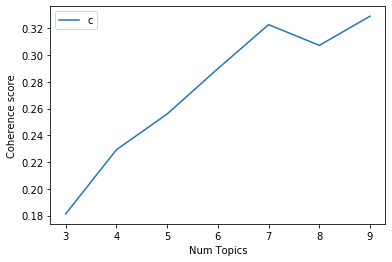

In [134]:
import matplotlib.pyplot as plt

mallet_coh_val = [coh for model, coh, topic in mallet_noun_adj_models]

x = range(3, 10)
plt.plot(x, mallet_coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [135]:
# Mallet LDA Model - topics
for model in mallet_noun_adj_models:
    print("Model #{} Coherence Score: {}".format(model[2], model[1]))
    topics = model[0].show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    print('----------------------------------------------------------------------------')

Model #3 Coherence Score: 0.18127995339888828
Topic 1: good, battery, camera, great, quality, nice, life, excellent, awesome, performance
Topic 2: price, product, mobile, great, sim, money, happy, device, smartphone, year
Topic 3: screen, time, easy, problem, day, apps, card, size, perfect, big
----------------------------------------------------------------------------
Model #4 Coherence Score: 0.22922448019850838
Topic 1: mobile, time, problem, happy, product, year, bad, month, service, apple
Topic 2: sim, apps, card, lot, memory, thing, issue, fine, bit, work
Topic 3: good, battery, camera, screen, quality, life, awesome, day, performance, display
Topic 4: great, price, nice, excellent, product, easy, good, device, screen, smartphone
----------------------------------------------------------------------------
Model #5 Coherence Score: 0.2559319012463308
Topic 1: happy, year, service, apple, charger, case, cell, work, purchase, unlocked
Topic 2: great, easy, device, smartphone, size,

In [110]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(gensim_noun_adj_models, open("mallet_noun_adj_models.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# gensim_models = pickle.load(open("mallet_noun_adj_models.pkl", "rb"))

NameError: name 'gensim_noun_adj_models' is not defined

# Sentiment Analysis (Vader & TextBlob)

### Common methods between both SA Models


In [96]:
#Takes in the sentence column from sentence_df, returns a list of polarity scores.
#Arg input 0 for Vader, 1 for TextBlob

def sa_score(name_df,arg_num):
    scores =[]
    
    if arg_num == 0:
        try:
            for sentence_value in name_df['sentence']:
                score = analyser.polarity_scores(sentence_value)
                scores.append(score)
        except Exception as e:
            print(str(e))
    else:        
        for sentence_value in name_df['sentence']:
            tb = TextBlob(sentence_value)
            scores.append(tb.sentiment.polarity)
    
    return scores
    

In [102]:
#Discrepancy between the extract's review score and the sentiment analysis's model score
#Takes in a dataframe, returns a list

def discrepancy(sa_df):
    discrepancy_list = []
    
    for index, row in sa_df.iterrows():
        if row['compound'] >= 0.3 and row['index scores'] < 6:
            discrepancy_list.append(1)
        elif -0.3 > row['compound'] > 0.3 and not(4 > row['index scores'] > 6):
            discrepancy_list.append(1)
        elif row['compound'] <= -0.3 and row['index scores'] > 4:
            discrepancy_list.append(1)
        else:
            discrepancy_list.append(0)
    
    return discrepancy_list

In [107]:
def discrepancy_score(sa_df2):
    sentencesDiscrepency = sa_df2.loc[sa_df2['discrepancy'] == 1]
    return(len(sentencesDiscrepency)/len(sa_df2))

In [98]:
sentences_df_sa = sentences_df.copy(deep=True)
#Drop all columns except sentence & index
sentences_df_sa.drop(sentences_df_sa.columns.difference(['sentence','index']), 1, inplace=True)

# VADER

In [99]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [112]:
"""scores =[]

try:
    for sentence_value in sentences_df['sentence']:
        score = analyser.polarity_scores(sentence_value)
        scores.append(score)
except Exception as e:
    print(str(e))
"""

In [100]:
vader_scores = sa_score(sentences_df_sa,0)
sentencesScores = pd.concat([sentences_df_sa,pd.DataFrame(vader_scores)],axis =1, sort = False)
sentencesScores['index scores'] = index_score_list
sentencesScores

,sentence,index,neg,neu,pos,compound,index scores
0,As a diehard Samsung fan who has had every Sam...,0,0.000,0.813,0.187,0.6486,10.0
1,I am amazed at some of the reviews and think p...,0,0.111,0.766,0.123,0.0772,10.0
2,The battery life is amazing,0,0.000,0.513,0.487,0.5859,10.0
3,Love the phone,1,0.000,0.323,0.677,0.6369,10.0
4,the phone is sleek and smooth and beautiful I ...,1,0.000,0.653,0.347,0.8412,10.0
...,...,...,...,...,...,...,...
983119,Came right on timr,400060,0.000,1.000,0.000,0.0000,10.0
983120,Excelente producto,400061,0.000,1.000,0.000,0.0000,10.0
983121,"Older Android version, too many junky apps and...",400062,0.000,1.000,0.000,0.0000,4.0
983122,I had one die and returned it to my cell provi...,400062,0.183,0.599,0.219,0.0516,4.0


In [103]:
"""discrepency = []

for index, row in sentencesScores.iterrows():
    if row['compound'] >= 0.3 and row['index scores'] < 6:
        discrepency.append(1)
    elif -0.3 > row['compound'] > 0.3 and not(4 > row['index scores'] > 6):
        discrepency.append(1)
    elif row['compound'] <= -0.3 and row['index scores'] > 4:
        discrepency.append(1)
    else:
        discrepency.append(0)"""
        
sentencesScores['discrepancy'] = discrepancy(sentencesScores)
sentencesScores

,sentence,index,neg,neu,pos,compound,index scores,discrepancy
0,As a diehard Samsung fan who has had every Sam...,0,0.000,0.813,0.187,0.6486,10.0,0
1,I am amazed at some of the reviews and think p...,0,0.111,0.766,0.123,0.0772,10.0,0
2,The battery life is amazing,0,0.000,0.513,0.487,0.5859,10.0,0
3,Love the phone,1,0.000,0.323,0.677,0.6369,10.0,0
4,the phone is sleek and smooth and beautiful I ...,1,0.000,0.653,0.347,0.8412,10.0,0
...,...,...,...,...,...,...,...,...
983119,Came right on timr,400060,0.000,1.000,0.000,0.0000,10.0,0
983120,Excelente producto,400061,0.000,1.000,0.000,0.0000,10.0,0
983121,"Older Android version, too many junky apps and...",400062,0.000,1.000,0.000,0.0000,4.0,0
983122,I had one die and returned it to my cell provi...,400062,0.183,0.599,0.219,0.0516,4.0,0


In [108]:
"""sentencesDiscrepency = sentencesScores.loc[sentencesScores['discrepancy'] == 1]
len(sentencesDiscrepency)/len(sentencesScores)
#print(sentencesDiscrepency.to_csv("discrepency.csv"))"""

vader_discrepancy_score = discrepancy_score(sentencesScores)
print(vader_discrepancy_score)

0.07754159190498859


In [109]:
###@@@@@@@@@ THIS IS TO ***SAVE*** THE VADER DF FROM ABOVE @@@@@@@@@###
#pickle.dump(sentencesScores, open("VaderSentencesScores.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE VADER DF FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# sentencesScores = pickle.load(open("VaderSentencesScores.pkl", "rb"))

## TextBlob

In [111]:
textblob_scores = sa_score(sentences_df_sa,1)

In [114]:
#textblob_sentencesScores = pd.concat([sentences_df_sa,pd.DataFrame(textblob_scores)],axis =1, sort = False)
#textblob_sentencesScores['index scores'] = index_score_list
textblob_sentencesScores.rename(columns={0: 'compound'}, inplace=True)
textblob_sentencesScores

,sentence,index,compound,index scores
0,As a diehard Samsung fan who has had every Sam...,0,0.300000,10.0
1,I am amazed at some of the reviews and think p...,0,0.000000,10.0
2,The battery life is amazing,0,0.600000,10.0
3,Love the phone,1,0.500000,10.0
4,the phone is sleek and smooth and beautiful I ...,1,0.470000,10.0
...,...,...,...,...
983119,Came right on timr,400060,0.285714,10.0
983120,Excelente producto,400061,0.000000,10.0
983121,"Older Android version, too many junky apps and...",400062,0.222222,4.0
983122,I had one die and returned it to my cell provi...,400062,0.300000,4.0


In [115]:
textblob_sentencesScores['discrepancy'] = discrepancy(textblob_sentencesScores)
textblob_sentencesScores.head()

,sentence,index,compound,index scores,discrepancy
0,As a diehard Samsung fan who has had every Sam...,0,0.30,10.0,0
1,I am amazed at some of the reviews and think p...,0,0.00,10.0,0
2,The battery life is amazing,0,0.60,10.0,0
3,Love the phone,1,0.50,10.0,0
4,the phone is sleek and smooth and beautiful I ...,1,0.47,10.0,0


In [117]:
textblob_discrepancy_score = discrepancy_score(textblob_sentencesScores)
print(textblob_discrepancy_score)

0.04196520479613965


In [118]:
###@@@@@@@@@ THIS IS TO ***SAVE*** THE TextBlob DF FROM ABOVE @@@@@@@@@###
pickle.dump(textblob_sentencesScores, open("TextBlobSentencesScores.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE TextBlob DF FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# textblob_sentencesScores = pickle.load(open("TextBlobSentencesScores.pkl", "rb"))

In [121]:
textblob_sentencesScores.head(50)

,sentence,index,compound,index scores,discrepancy
0,As a diehard Samsung fan who has had every Sam...,0,0.300000,10.0,0
1,I am amazed at some of the reviews and think p...,0,0.000000,10.0,0
2,The battery life is amazing,0,0.600000,10.0,0
3,Love the phone,1,0.500000,10.0,0
4,the phone is sleek and smooth and beautiful I ...,1,0.470000,10.0,0
5,Adequate feel,2,0.333333,6.0,0
6,Nice heft,2,0.600000,6.0,0
7,Processor's still sluggish for the few apps th...,2,-0.200000,6.0,0
8,Samsung wants to vacuum all of your data with ...,2,0.230556,6.0,0
9,What else is new,2,0.136364,6.0,0


# EVERYTHING BELOW ARE VERSION 1 CODE

# LDA Model

In [69]:
# Preprocessing of extracts into words

import nltk
import re
import gensim

def clean_extract(extract_data):
    stop_list = nltk.corpus.stopwords.words('english')
    stop_list += ['phone', 'iphone', 'nokia', 'samsung', 'htc', 'lg', 'galaxy', 'ca', 'motorola', 'android', 'verizon']
    tokenizer = nltk.tokenize.word_tokenize
    stemmer = nltk.stem.porter.PorterStemmer()

    extract_list  = [tokenizer(extract) for extract in extract_data]
    extract_list = [[w.lower() for w in extract] for extract in extract_list]
    extract_list = [[w for w in extract if re.search('^[a-z]+$',w)] for extract in extract_list]
    extract_list = [[w for w in extract if w not in stop_list] for extract in extract_list]
#     extract_list = [[stemmer.stem(w) for w in extract] for extract in extract_list]
    return extract_list

In [31]:
extract_list = cleaned_df['extract'].values.tolist()
extract_words = clean_extract(extract_list)

## Gensim LDA Model

In [32]:
import gensim

# Using gensim to create a dictionary object of all the words in all extracts
extract_dict = gensim.corpora.Dictionary(extract_words)

# Returning the word vector for each extract from the gensim dict of words
extract_vecs = [extract_dict.doc2bow(extract) for extract in extract_words]

In [34]:
# Finding the optimal number of topics
from gensim.models import CoherenceModel

model_list = []
coh_val = []
model_topics = []

for num_topic in range(3, 10):
    extract_lda_gensim = gensim.models.ldamodel.LdaModel(corpus=extract_vecs, id2word=extract_dict, num_topics=num_topic)
    coh_model = CoherenceModel(model=extract_lda_gensim, texts=extract_words, dictionary=extract_dict, coherence='c_v')
    model_topics.append(num_topic)
    model_list.append(extract_lda_gensim)
    coh_val.append(coh_model.get_coherence())
    print("Topic " + str(num_topic) + " Score: " + str(coh_model.get_coherence()))

Topic 3 Score: 0.4002669529670479
Topic 4 Score: 0.4327363705646269
Topic 5 Score: 0.41127359587131307
Topic 6 Score: 0.41417195899660714
Topic 7 Score: 0.43815965947182983
Topic 8 Score: 0.45251749430692023
Topic 9 Score: 0.4166528935165106


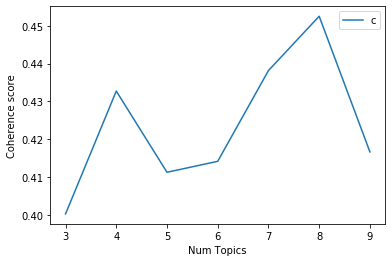

In [44]:
import matplotlib.pyplot as plt

x = range(3, 10)
plt.plot(x, coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Gensim LDA Model - topics
val = 0
model_num = 3
for model in model_list:
    print("Model #{} Coherence Score: {}".format(model_num, coh_val[val]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    model_num += 1
    val += 1
    print('----------------------------------------------------------------------------')

Model #3 Coherence Score: 0.4002669529670479
Topic 1: phone, one, got, bought, phones, new, would, get, first, iphone
Topic 2: phone, screen, great, use, camera, easy, love, like, features, nice
Topic 3: good, phone, battery, great, works, product, life, price, sim, card
----------------------------------------------------------------------------
Model #4 Coherence Score: 0.4327363705646269
Topic 1: phone, screen, use, easy, like, great, love, touch, small, really
Topic 2: good, phone, battery, camera, great, quality, life, price, excellent, nice
Topic 3: phone, phones, one, iphone, samsung, best, nokia, years, ever, love
Topic 4: phone, one, would, work, bought, got, get, new, use, great
----------------------------------------------------------------------------
Model #5 Coherence Score: 0.41127359587131307
Topic 1: phone, work, would, get, sim, time, working, got, problem, back
Topic 2: good, battery, phone, camera, quality, life, screen, great, mobile, best
Topic 3: good, phone, pr

In [37]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE GENSIM MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(model_list, open("gensim_models.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# gensim_models = pickle.load(open("gensim_models.pkl", "rb"))

## Mallet LDA Model

In [38]:
import gensim
import os 

os.environ.update({'MALLET_HOME':r'D:\\Softwares\\mallet-2.0.8'})
mallet_path = r'D:\\Softwares\\mallet-2.0.8\\bin\\mallet'

model_list_mallet = []
coh_val_mallet = []

for num_topic in range(3, 10):
    extract_lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=extract_vecs, id2word=extract_dict, num_topics=num_topic)
    coh_model_mallet = CoherenceModel(model=extract_lda_mallet, texts=extract_words, dictionary=extract_dict, coherence='c_v')
    model_list_mallet.append(extract_lda_mallet)
    coh_val_mallet.append(coh_model_mallet.get_coherence())
    print("Topic " + str(num_topic) + " Score: " + str(coh_model_mallet.get_coherence()))

Topic 3 Score: 0.40153661259582235
Topic 4 Score: 0.39716823484276176
Topic 5 Score: 0.43003942023445385
Topic 6 Score: 0.46741532979935946
Topic 7 Score: 0.4791484852124435
Topic 8 Score: 0.4865505900403278
Topic 9 Score: 0.494983106220992


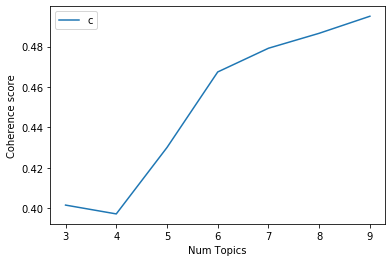

In [39]:
import matplotlib.pyplot as plt

x = range(3, 10)
plt.plot(x, coh_val_mallet)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [43]:
# Mallet LDA Model - topics
val = 0
mallet_model_num = 3
for model in model_list_mallet:
    print("Model #{} Coherence Score: {}".format(mallet_model_num, coh_val_mallet[val]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    mallet_model_num += 1
    val += 1
    print('----------------------------------------------------------------------------')

Model #3 Coherence Score: 0.40153661259582235
Topic 1: good, great, battery, camera, price, quality, product, nice, mobile, life
Topic 2: phone, love, screen, phones, samsung, iphone, easy, galaxy, great, android
Topic 3: phone, bought, works, time, buy, work, back, months, sim, working
----------------------------------------------------------------------------
Model #4 Coherence Score: 0.39716823484276176
Topic 1: battery, phone, time, work, product, back, life, problem, months, apps
Topic 2: good, camera, great, price, screen, quality, nice, features, mobile, excellent
Topic 3: phone, great, love, easy, screen, works, lot, smart, touch, ca
Topic 4: phone, bought, phones, samsung, iphone, android, galaxy, happy, nokia, years
----------------------------------------------------------------------------
Model #5 Coherence Score: 0.43003942023445385
Topic 1: price, product, samsung, mobile, iphone, buy, features, android, galaxy, money
Topic 2: phone, work, time, problem, working, months

In [41]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MALLET MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(model_list_mallet, open("mallet_models.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# mallet_models = pickle.load(open("mallet_models.pkl", "rb"))

In [46]:
## Another Gensim run with more words taken out from the stop list 
import nltk
import re
import gensim

def clean_extract2(extract_data):
    stop_list = nltk.corpus.stopwords.words('english')
    stop_list += ['phone', 'iphone', 'nokia', 'samsung', 'htc', 'lg', 'galaxy', 'ca', '']
    tokenizer = nltk.tokenize.word_tokenize
    stemmer = nltk.stem.porter.PorterStemmer()

    extract_list  = [tokenizer(extract) for extract in extract_data]
    extract_list = [[w.lower() for w in extract] for extract in extract_list]
    extract_list = [[w for w in extract if re.search('^[a-z]+$',w)] for extract in extract_list]
    extract_list = [[w for w in extract if w not in stop_list] for extract in extract_list]
#     extract_list = [[stemmer.stem(w) for w in extract] for extract in extract_list]
    return extract_list

In [47]:
extract_list2 = cleaned_df['extract'].values.tolist()
extract_words2 = clean_extract2(extract_list2)

In [48]:
import gensim

# Using gensim to create a dictionary object of all the words in all extracts
extract_dict2 = gensim.corpora.Dictionary(extract_words2)

# Returning the word vector for each extract from the gensim dict of words
extract_vecs2 = [extract_dict2.doc2bow(extract) for extract in extract_words2]

In [49]:
# Finding the optimal number of topics
from gensim.models import CoherenceModel

model_list2 = []
coh_val2 = []
model_topics2 = []

for num_topic in range(3, 10):
    extract_lda_gensim2 = gensim.models.ldamodel.LdaModel(corpus=extract_vecs2, id2word=extract_dict2, num_topics=num_topic)
    coh_model2 = CoherenceModel(model=extract_lda_gensim2, texts=extract_words2, dictionary=extract_dict2, coherence='c_v')
    model_topics2.append(num_topic)
    model_list2.append(extract_lda_gensim2)
    coh_val2.append(coh_model2.get_coherence())
    print("Topic " + str(num_topic) + " Score: " + str(coh_model2.get_coherence()))

Topic 3 Score: 0.37720979072736577
Topic 4 Score: 0.4129551343848196
Topic 5 Score: 0.3671427833870802
Topic 6 Score: 0.42117797065136936
Topic 7 Score: 0.41291882112235495
Topic 8 Score: 0.4313795092804904
Topic 9 Score: 0.44016334248403677


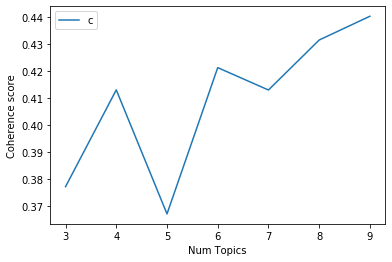

In [51]:
import matplotlib.pyplot as plt

x = range(3, 10)
plt.plot(x, coh_val2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [53]:
# 2nd Gensim LDA Model - topics
val2 = 0
model_num2 = 3
for model in model_list2:
    print("Model #{} Coherence Score: {}".format(model_num2, coh_val2[val2]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list2 = []
        for word, word_prob in word_list:
            result_list2.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list2)))
    model_num2 += 1
    val2 += 1
    print('----------------------------------------------------------------------------')

Model #3 Coherence Score: 0.37720979072736577
Topic 1: battery, work, use, get, screen, one, would, time, got, like
Topic 2: one, phones, great, love, bought, new, like, got, first, would
Topic 3: good, great, camera, screen, quality, nice, easy, battery, excellent, use
----------------------------------------------------------------------------
Model #4 Coherence Score: 0.4129551343848196
Topic 1: work, would, sim, card, working, get, new, use, back, problem
Topic 2: battery, good, screen, camera, quality, life, great, nice, touch, like
Topic 3: great, good, love, use, easy, like, works, really, price, everything
Topic 4: one, phones, first, best, got, get, bought, years, ever, new
----------------------------------------------------------------------------
Model #5 Coherence Score: 0.3671427833870802
Topic 1: best, ever, mobile, smartphone, owned, phones, one, sony, market, android
Topic 2: battery, good, life, card, sim, charge, use, memory, apps, ok
Topic 3: great, good, works, pro

In [54]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MALLET MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(model_list2, open("gensim_models2.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# mallet_models = pickle.load(open("mallet_models.pkl", "rb"))

In [55]:
# 2nd Mallet LDA Model
import gensim
import os 

os.environ.update({'MALLET_HOME':r'D:\\Softwares\\mallet-2.0.8'})
mallet_path = r'D:\\Softwares\\mallet-2.0.8\\bin\\mallet'

model_list_mallet2 = []
coh_val_mallet2 = []

for num_topic in range(3, 10):
    extract_lda_mallet2 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=extract_vecs2, id2word=extract_dict2, num_topics=num_topic)
    coh_model_mallet2 = CoherenceModel(model=extract_lda_mallet2, texts=extract_words2, dictionary=extract_dict2, coherence='c_v')
    model_list_mallet2.append(extract_lda_mallet2)
    coh_val_mallet2.append(coh_model_mallet2.get_coherence())
    print("Topic " + str(num_topic) + " Score: " + str(coh_model_mallet2.get_coherence()))

Topic 3 Score: 0.33886764510583456
Topic 4 Score: 0.40415441462936047
Topic 5 Score: 0.4297441330925132
Topic 6 Score: 0.442586226238539
Topic 7 Score: 0.44981361903050854
Topic 8 Score: 0.4711436807881638
Topic 9 Score: 0.49534991688020447


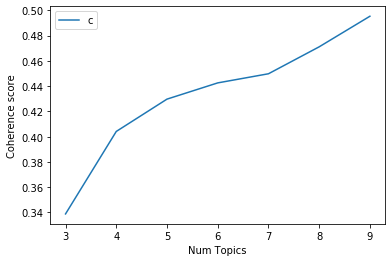

In [56]:
import matplotlib.pyplot as plt

x = range(3, 10)
plt.plot(x, coh_val_mallet2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Mallet LDA Model - topics
val = 0
mallet_model_num = 3
for model in model_list_mallet2:
    print("Model #{} Coherence Score: {}".format(mallet_model_num, coh_val_mallet2[val]))
    topics = model.show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    mallet_model_num += 1
    val += 1
    print('----------------------------------------------------------------------------')

Model #3 Coherence Score: 0.33886764510583456
Topic 1: great, love, battery, bought, phones, product, easy, buy, life, time
Topic 2: works, work, back, problem, sim, working, card, bad, problems, months
Topic 3: good, camera, screen, price, great, quality, nice, mobile, excellent, fast
----------------------------------------------------------------------------
Model #4 Coherence Score: 0.40415441462936047
Topic 1: good, battery, camera, quality, price, nice, mobile, life, fast, excellent
Topic 2: great, product, works, buy, work, apps, sim, happy, card, money
Topic 3: screen, love, great, phones, easy, features, android, touch, smartphone, size
Topic 4: time, back, bought, months, working, problem, days, problems, year, day
----------------------------------------------------------------------------
Model #5 Coherence Score: 0.4297441330925132
Topic 1: screen, phones, android, device, years, size, big, bit, note, perfect
Topic 2: good, camera, price, quality, nice, mobile, excellent, 

In [58]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MALLET MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(model_list_mallet2, open("mallet_models2.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE GENSIM MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
# mallet_models = pickle.load(open("mallet_models.pkl", "rb"))

In [ ]:
## Another Gensim run with more words taken out from the stop list 
import nltk
import re
import gensim

def clean_extract2(extract_data):
    stop_list = nltk.corpus.stopwords.words('english')
    stop_list += ['phone', 'iphone', 'nokia', 'samsung', 'htc', 'lg', 'galaxy', 'ca', '']
    tokenizer = nltk.tokenize.word_tokenize
    stemmer = nltk.stem.porter.PorterStemmer()

    extract_list  = [tokenizer(extract) for extract in extract_data]
    extract_list = [[w.lower() for w in extract] for extract in extract_list]
    extract_list = [[w for w in extract if re.search('^[a-z]+$',w)] for extract in extract_list]
    extract_list = [[w for w in extract if w not in stop_list] for extract in extract_list]
#     extract_list = [[stemmer.stem(w) for w in extract] for extract in extract_list]
    return extract_list

In [60]:
import nltk
import re

new_query = 'Good phone screen good battery life'
tokenizer = nltk.tokenize.word_tokenize
cleaned_query = tokenizer(new_query)
cleaned_query = [w.lower() for w in cleaned_query]
cleaned_query = [w for w in cleaned_query if re.search('^[a-z]+$',w)]

In [62]:
import gensim

# Returning the word vector for each extract from the gensim dict of words
query_vecs = extract_dict2.doc2bow(cleaned_query)

In [65]:
output = list(model_list_mallet2[4][query_vecs])

print(output)

[(0, 0.12987012987012989), (1, 0.12987012987012989), (2, 0.12987012987012989), (3, 0.12987012987012989), (4, 0.1662337662337662), (5, 0.14805194805194802), (6, 0.1662337662337662)]
